# Detección de Fuego usando CNN
## Este cuaderno implementa un modelo de Deep Learning basado en Redes Neuronales Convolucionales (CNN) para la detección de fuego en imágenes.

In [ ]:
# Importo librería necesarias

import pandas as pd
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from keras.layers import Dropout
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm
import cv2
from glob import glob
import seaborn as sns
sns.set()

import sklearn
import skimage
from skimage.transform import resize

import random
from skimage.color import rgb2gray
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score

In [ ]:
# Monto mi Google Drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Cargo el dataset y preparo los datos para entrenamiento y prueba

train = '/content/drive/MyDrive/Dataframes/fire_detection/Training and Validation'
test = '/content/drive/MyDrive/Dataframes/fire_detection/Testing'


LOAD_FROM_IMAGES = True

def get_data(folder):
    x = []
    y = []
    for folderName in os.listdir(folder):
        if not folderName.startswith("."):
            if folderName in ["nofire"]:
                label = 0
            elif folderName in ["fire"]:
                label = 1
            else:
                label = 2
            for image_filename in tqdm(os.listdir(folder +"/" +folderName+"/")):
                img_file = cv2.imread(folder + "/" +folderName + "/" + image_filename)
                if img_file is not None:
                    img_file = skimage.transform.resize(img_file,(128,128,3), mode = "constant",anti_aliasing=True)
                    #img_file = rgb2gray(img_file)
                    img_arr = np.asarray(img_file)
                    x.append(img_arr)
                    y.append(label)
    x = np.asarray(x)
    y = np.asarray(y)
    return x,y

if LOAD_FROM_IMAGES:
    X_train,y_train = get_data(train)
    X_test, y_test = get_data(test)

    np.save("xtrain.npy",X_train)
    np.save("ytrain.npy",y_train)
    np.save("xtest.npy",X_test)
    np.save("ytest.npy",y_test)
else:
    X_train = np.load("xtrain.npy")
    y_train = np.load("ytrain.npy")
    X_test = np.load("xtest.npy")
    y_test = np.load("ytest.npy")

100%|██████████| 22/22 [00:00<00:00, 55.89it/s]


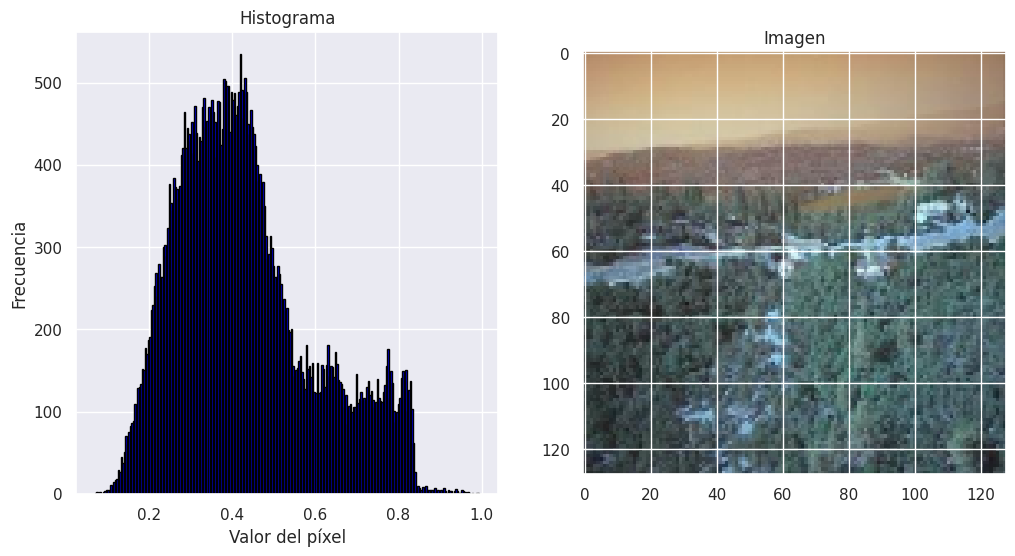

In [ ]:
# Análisis de las imágenes

import random

def plot_histogram():
    # Seleccionar una imagen aleatoria de X_train
    random_index = random.randint(0, len(X_train) - 1)
    imagen_aleatoria = X_train[random_index]

    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)

    # Mejorar la visualización del histograma
    plt.hist(imagen_aleatoria.ravel(), bins=255, color='blue', edgecolor='black')

    # Agregar etiquetas a los ejes
    plt.xlabel("Valor del píxel")
    plt.ylabel("Frecuencia")
    plt.title("Histograma")

    plt.subplot(1,2,2)
    plt.imshow(imagen_aleatoria,vmin=0,vmax=1, cmap="magma")
    plt.title("Imagen") # Agregar título a la imagen
    plt.show()

# Llamar a la función para visualizar una imagen aleatoria
plot_histogram()

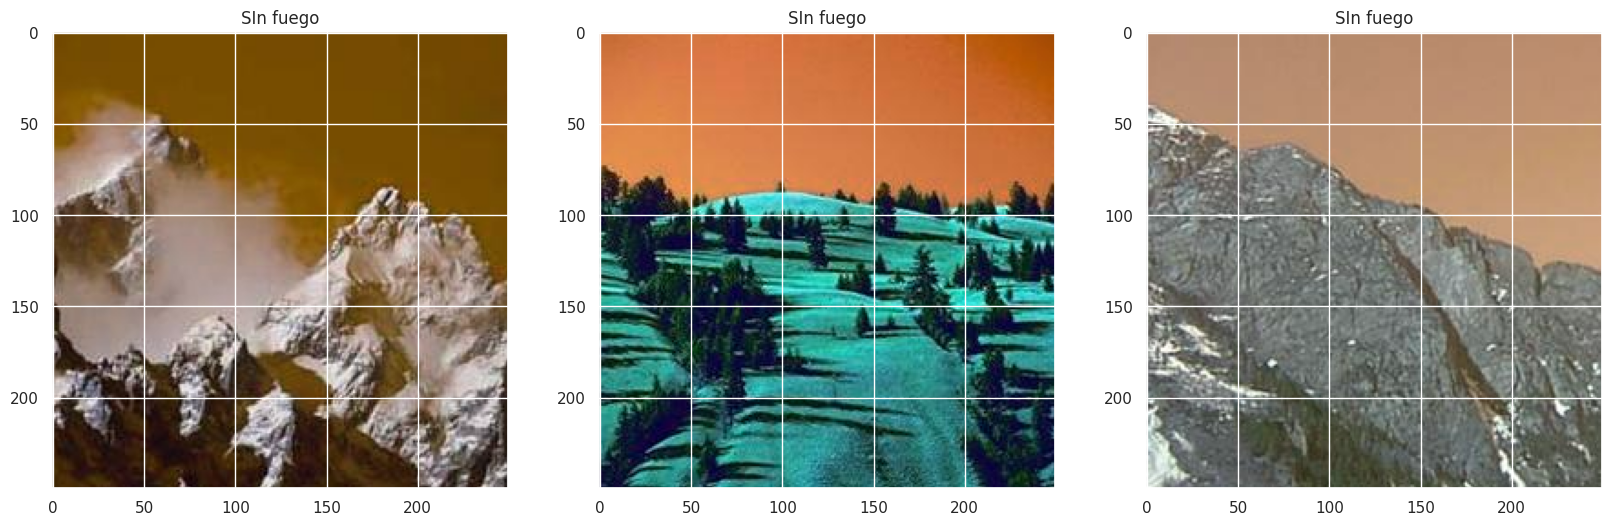

In [ ]:
# Sin fuego

glob_img = glob("/content/drive/MyDrive/Dataframes/fire_detection/Training and Validation/nofire/**")

def plot(images):
    num_images = len(images)
    if num_images < 3:
        print("Not enough images to plot.")
        return

    # Adjust sample size if needed
    sample_size = min(num_images, 3)

    z = random.sample(images, sample_size)
    plt.figure(figsize=(20, 20))

    # Plot the images
    for i, image_path in enumerate(z):
        plt.subplot(1, sample_size, i + 1)
        plt.imshow(cv2.imread(image_path), cmap="inferno")
        plt.title("SIn fuego")

plot(glob_img)

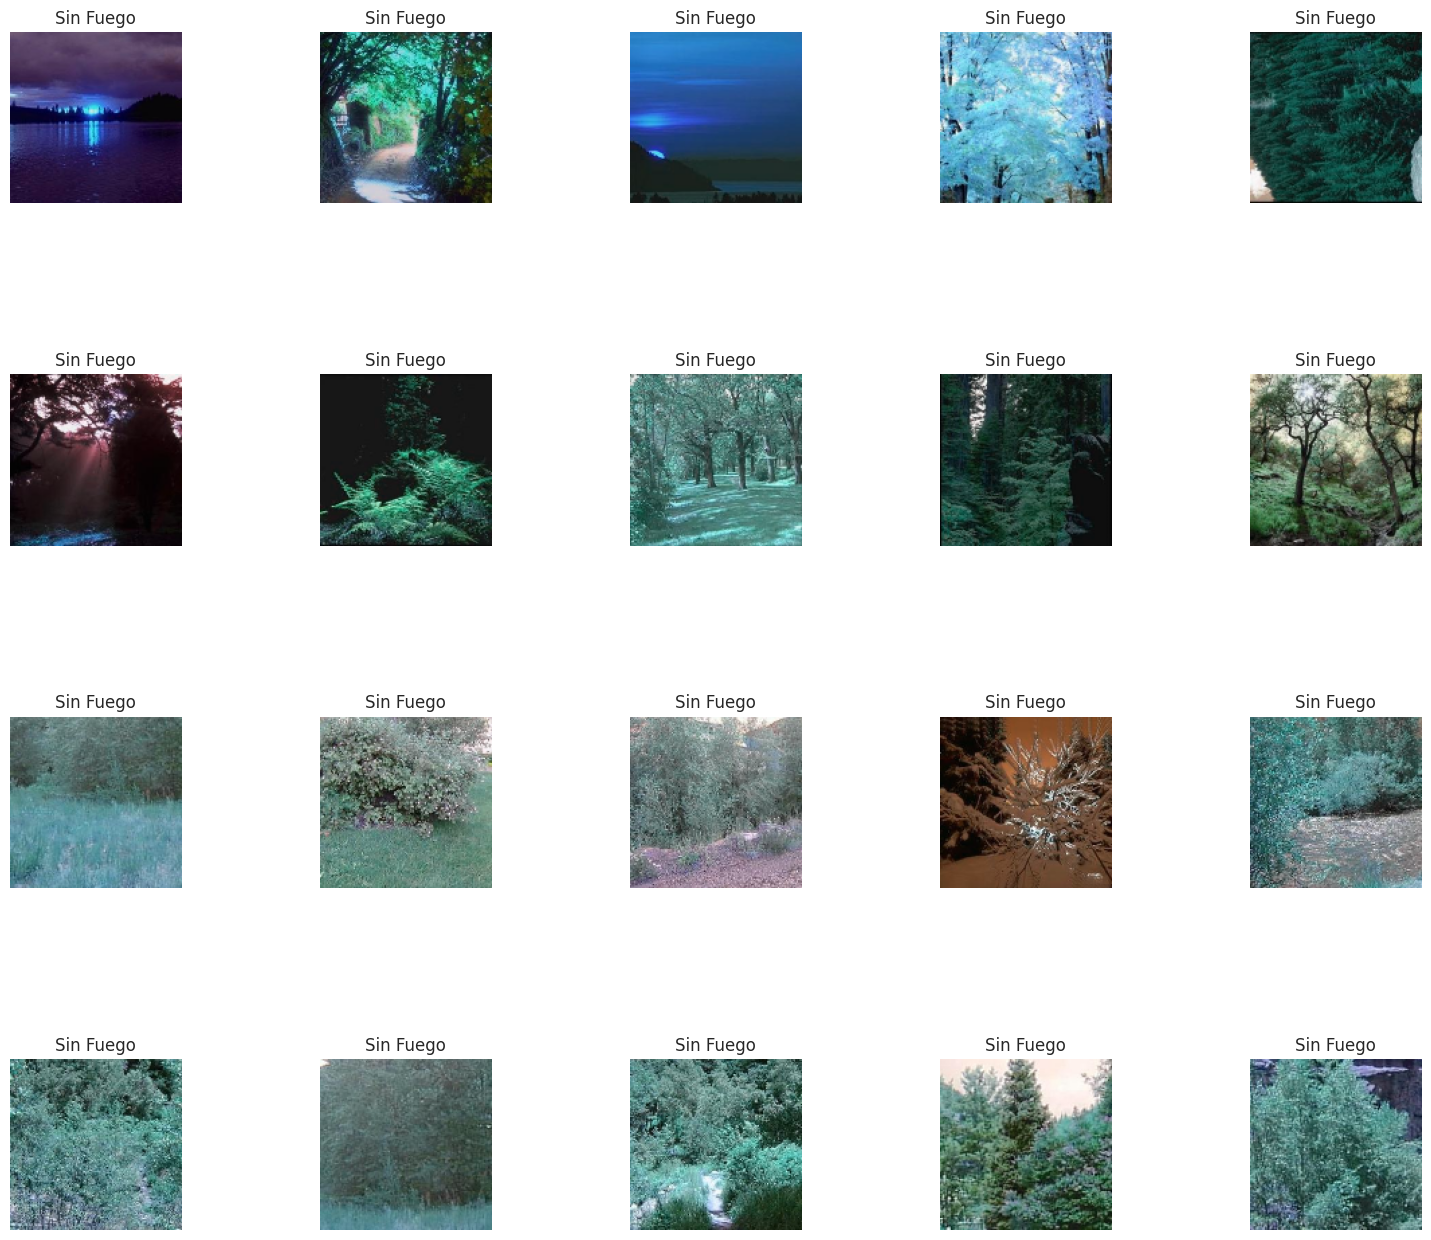

In [ ]:
# Sin fuego

glob_img = glob("/content/drive/MyDrive/Dataframes/fire_detection/Training and Validation/nofire/**")
i_=0
plt.rcParams["figure.figsize"] =(20.0,20.0)
plt.subplots_adjust(wspace=0,hspace=1)
for i in  glob_img[0:20]:
    img=cv2.imread(i)
    img=cv2.resize(img,(128,128))
    plt.subplot(5,5,i_+1)
    plt.imshow(img);plt.axis("off"); cmap="magma"
    plt.title("Sin Fuego") # Agregar título a la imagen
    i_ +=1

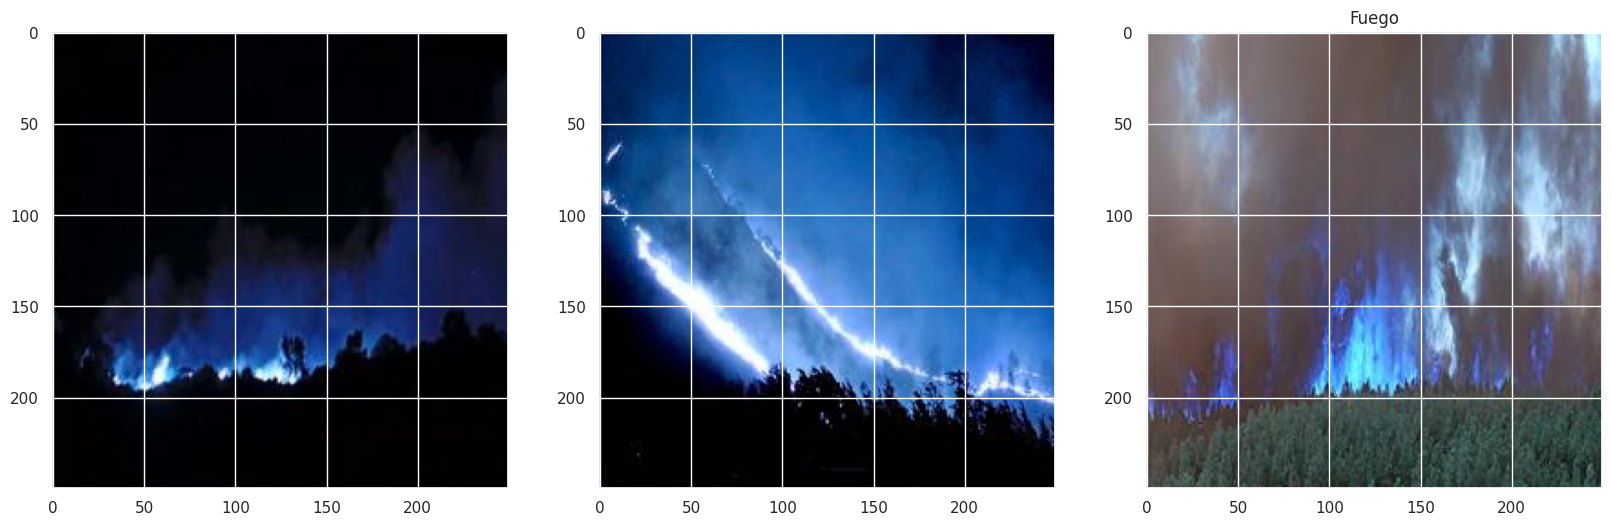

In [ ]:
# Fuego

glob_img = glob("/content/drive/MyDrive/Dataframes/fire_detection/Training and Validation/fire/**")

def plot(images):
    z = random.sample(images,3)
    plt.figure(figsize=(20,20))
    plt.subplot(131)
    plt.imshow(cv2.imread(z[0]))
    plt.subplot(132)
    plt.imshow(cv2.imread(z[1]))
    plt.subplot(133)
    plt.imshow(cv2.imread(z[2]), cmap="inferno")
    plt.title("Fuego")

plot(glob_img)


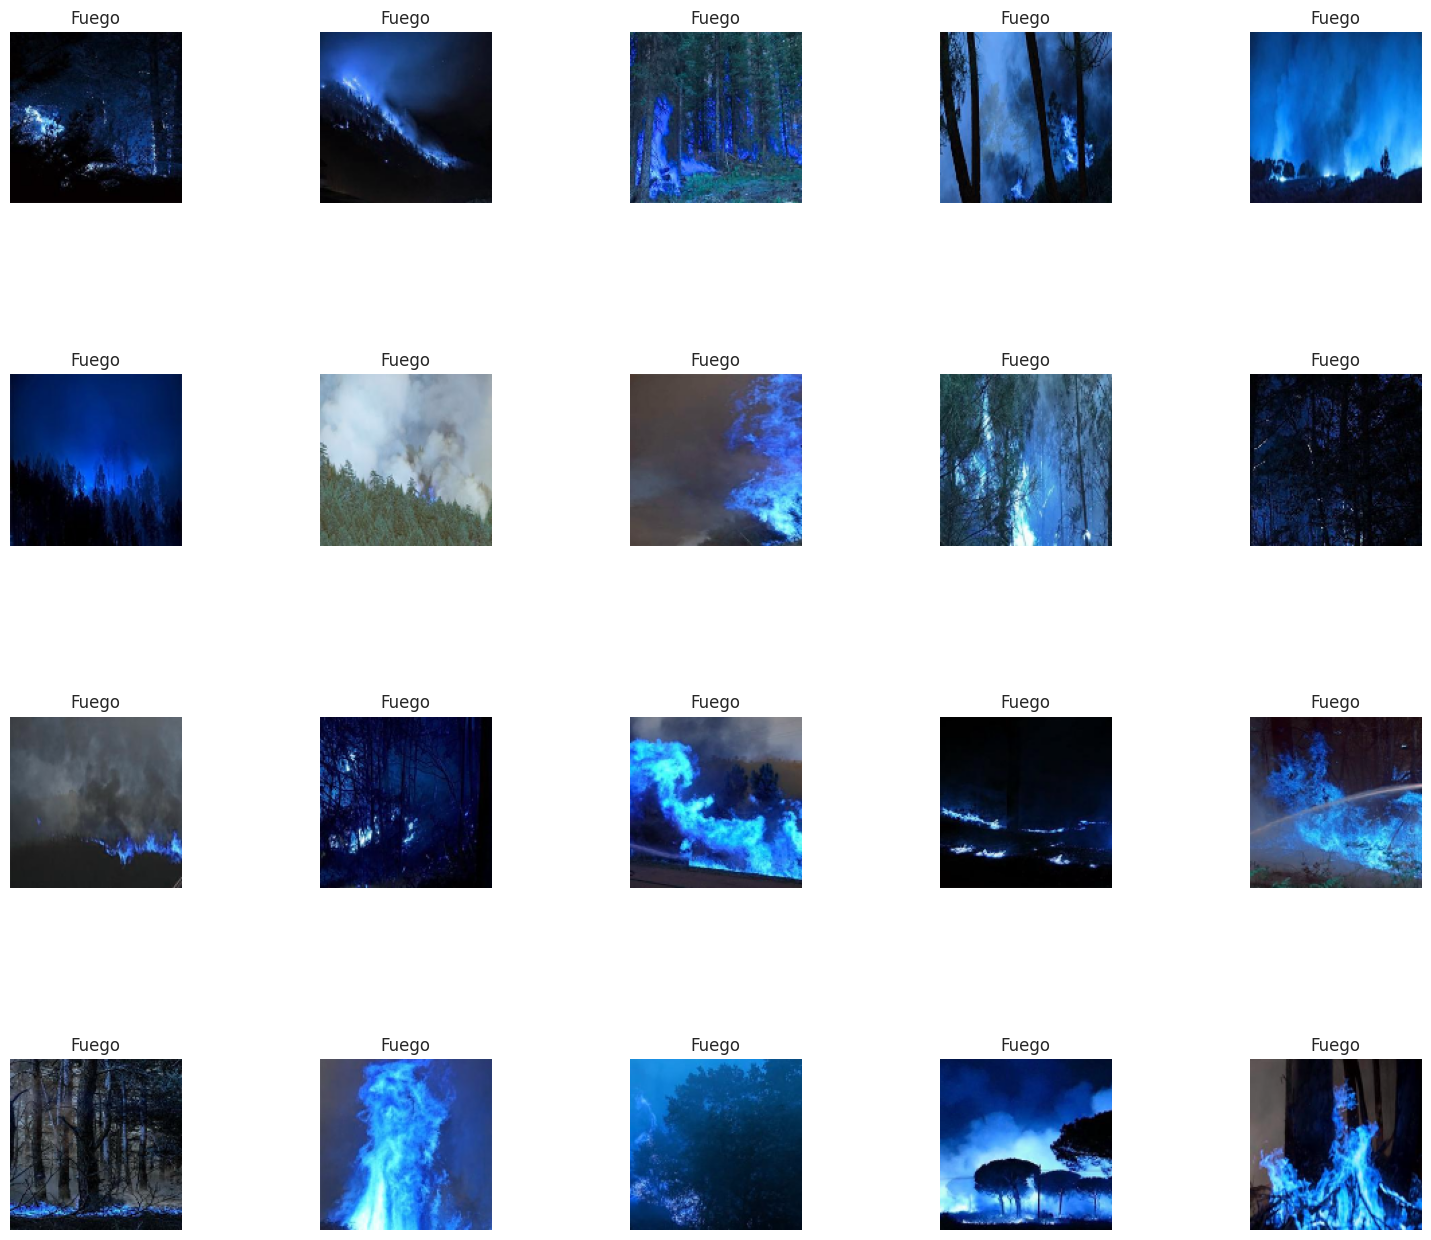

In [ ]:
# Fuego

glob_img = glob("/content/drive/MyDrive/Dataframes/fire_detection/Training and Validation/fire/**")
i_=0
plt.rcParams["figure.figsize"] =(20.0,20.0)
plt.subplots_adjust(wspace=0,hspace=1)
for i in  glob_img[0:20]:
    img=cv2.imread(i)
    img=cv2.resize(img,(128,128))
    plt.subplot(5,5,i_+1)
    plt.imshow(img);plt.axis("off"); cmap="inferno"
    plt.title("Fuego")
    i_ +=1

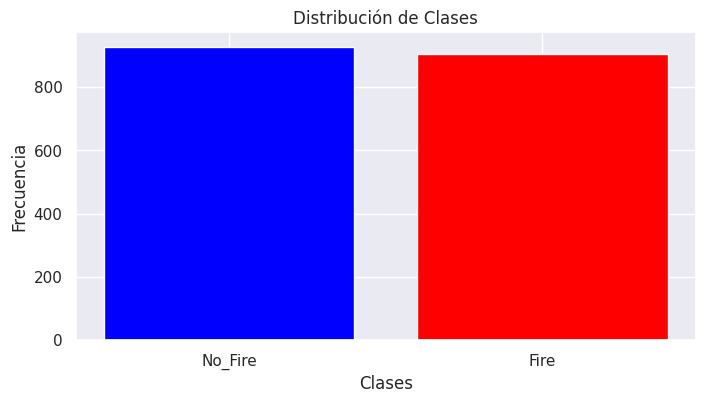

{0: 'No_Fire', 1: 'Fire'}


In [ ]:
# Visualizo la distribución de clases

plt.figure(figsize=(8,4))

map_characters = {0:"No_Fire",1:"Fire"}
dict_characters = map_characters

df = pd.DataFrame()
df["labels"]=y_train
lab = df["labels"]
dist=lab.value_counts()

# --- Cambios aquí ---
etiquetas = list(dict_characters.values())  # Obtener etiquetas de "No_Fire" y "Fire"
valores = dist.values  # Obtener los valores de frecuencia

plt.bar(etiquetas, valores, color=['blue', 'red']) # Crear gráfico de barras verticales
# --- Fin de los cambios ---

plt.xlabel("Clases")
plt.ylabel("Frecuencia")
plt.title("Distribución de Clases")
plt.show()

print(dict_characters)

In [ ]:
# Veo el tamaño del set de entrenamiento

X_train.shape

(1832, 128, 128, 3)

In [ ]:
# Incorporo Data Augmentation para incrementar el dataset

datagen = ImageDataGenerator(
       rotation_range=20,
       width_shift_range=0.2,
       height_shift_range=0.2,
       shear_range=0.2,
       zoom_range=0.2,
       horizontal_flip=True,
       fill_mode='nearest')

In [ ]:
datagen.fit(X_train)

In [ ]:
# Creo el modelo de tipo Sequential con capas convolucionales

model = models.Sequential()

model.add(layers.Conv2D(64,(3,3),activation="relu",input_shape=(128,128,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(layers.Conv2D(64,(3,3),activation="relu"))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(64,(3,3),activation="relu"))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())

model.add(layers.Dense(128,activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(layers.Dense(2,activation="softmax"))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
#  Resumen del modelo

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 126, 126, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 63, 63, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 63, 63, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 63, 63, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 61, 61, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,682,434 (6.42 MB)

 Trainable params: 1,682,050 (6.42 MB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
# Compilo el modelo

model.compile(optimizer = "adam" , loss = "sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
# Defino lotes y epocas

batch_size=8
epochs=50

In [ ]:
# Incorporo 'Early Stopping' para detener el entrenamiento de un modelo de aprendizaje automático cuando el rendimiento del modelo deja de mejorar.

from tensorflow.keras.callbacks import EarlyStopping

custom_early_stopping = EarlyStopping(
    monitor='accuracy',
    patience=80,
    restore_best_weights=True
)

In [ ]:
# Creo una función callback para guardar el modelo cada diez epocas por si se crashea

from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
       filepath='modelo_cnn_fuego_{epoch:02d}.keras',  # Nombre del archivo
       monitor='accuracy',  # Métrica a monitorear
       save_freq=10,  # Guardar después de cada época
       # period=10  # Guardar cada 10 épocas
   )

In [ ]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                       epochs=epochs,
                       validation_data=(X_test, y_test),
                       callbacks=[custom_early_stopping, checkpoint_callback])

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


229/229 ━━━━━━━━━━━━━━━━━━━━ 125s 530ms/step - accuracy: 0.8235 - loss: 0.4796 - val_accuracy: 0.8235 - val_loss: 0.4641
Epoch 2/20
229/229 ━━━━━━━━━━━━━━━━━━━━ 119s 519ms/step - accuracy: 0.8588 - loss: 0.3762 - val_accuracy: 0.9265 - val_loss: 0.2743
Epoch 3/20
229/229 ━━━━━━━━━━━━━━━━━━━━ 124s 542ms/step - accuracy: 0.8944 - loss: 0.2742 - val_accuracy: 0.9265 - val_loss: 0.2681
Epoch 4/20
229/229 ━━━━━━━━━━━━━━━━━━━━ 125s 546ms/step - accuracy: 0.8997 - loss: 0.2587 - val_accuracy: 0.8382 - val_loss: 0.4035
Epoch 5/20
229/229 ━━━━━━━━━━━━━━━━━━━━ 119s 520ms/step - accuracy: 0.8948 - loss: 0.2745 - val_accuracy: 0.8529 - val_loss: 0.5187
Epoch 6/20
229/229 ━━━━━━━━━━━━━━━━━━━━ 120s 524ms/step - accuracy: 0.9059 - loss: 0.2492 - val_accuracy: 0.8824 - val_loss: 0.3183
Epoch 7/20
229/229 ━━━━━━━━━━━━━━━━━━━━ 120s 524ms/step - accuracy: 0.9053 - loss: 0.2414 - val_accuracy: 0.8824 - val_loss: 0.3095
Epoch 8/20
229/229 ━━━━━━━━━━━━━━━━━━━━ 120s 526ms/step - accuracy: 0.9229 - loss: 0.23

In [ ]:
score = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.9634 - loss: 0.1050
Test loss: 0.1766243427991867
Test accuracy: 0.9264705777168274


In [ ]:
y_test_pred = model.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step


In [ ]:
y_pred = (y_test_pred > 0.5)
y_pred=np.argmax(y_pred, axis=1)

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
y_pred.shape

(68,)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95        46
           1       0.95      0.82      0.88        22

    accuracy                           0.93        68
   macro avg       0.93      0.90      0.91        68
weighted avg       0.93      0.93      0.92        68



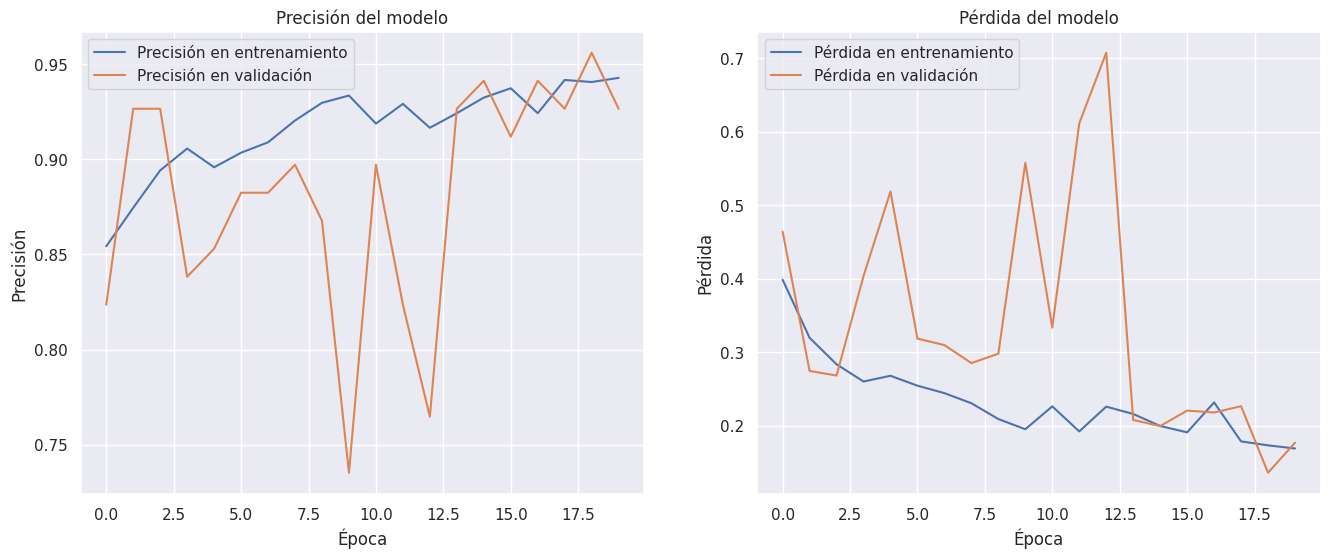

In [ ]:
# Obtener la precisión y la pérdida del historial
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Crear la figura y los ejes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))  # 1 fila, 2 columnas

# Gráfico de precisión
ax1.plot(accuracy, label='Precisión en entrenamiento')
ax1.plot(val_accuracy, label='Precisión en validación')
ax1.set_xlabel('Época')
ax1.set_ylabel('Precisión')
ax1.set_title('Precisión del modelo')
ax1.legend()

# Gráfico de pérdida
ax2.plot(loss, label='Pérdida en entrenamiento')
ax2.plot(val_loss, label='Pérdida en validación')
ax2.set_xlabel('Época')
ax2.set_ylabel('Pérdida')
ax2.set_title('Pérdida del modelo')
ax2.legend()

# Mostrar el gráfico
plt.show()

In [ ]:
def confusion(y_test,y_test_pred,X):
    names=['No Fire','Fire']
    cm=confusion_matrix(y_test,y_test_pred)
    f,ax=plt.subplots(figsize=(10,10))
    sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
    plt.title(X, size = 25)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()

    return

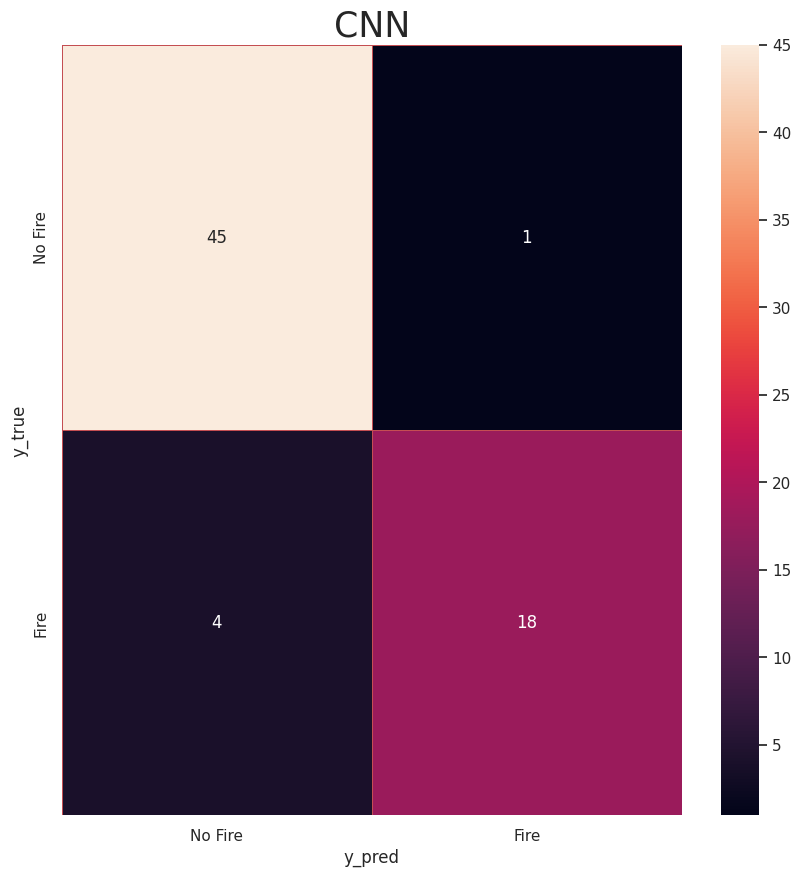

In [ ]:
confusion(y_test,y_pred,"CNN")

In [ ]:
# Guardo el modelo

model.save('modelo_cnn_fuego_final.keras')

from google.colab import files

files.download('modelo_cnn_fuego_final.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Creo una funcion para comprobar la precisión del modelo cargando una imagen aleatoria del dataset

import numpy as np
import matplotlib.pyplot as plt
import random

def probar_modelo_con_imagen_aleatoria(modelo, X_test, y_test, map_characters):
    """
    Prueba el modelo con una imagen aleatoria del conjunto de prueba y muestra la predicción.

    Args:
        modelo: El modelo entrenado.
        X_test: El conjunto de datos de imágenes de prueba.
        y_test: Las etiquetas verdaderas del conjunto de prueba.
        map_characters: Un diccionario que mapea las etiquetas numéricas a nombres de clases.
    """
    # Seleccionar una imagen aleatoria del conjunto de prueba
    random_index = random.randint(0, len(X_test) - 1)
    imagen = X_test[random_index]
    etiqueta_verdadera = y_test[random_index]

    # Predecir la clase de la imagen
    prediccion = modelo.predict(np.expand_dims(imagen, axis=0))[0]
    clase_predicha = np.argmax(prediccion)

    # Mostrar la imagen y la predicción
    plt.imshow(imagen, cmap="gray")
    plt.title(f"Etiqueta verdadera: {map_characters[etiqueta_verdadera]}, "
              f"Predicción: {map_characters[clase_predicha]}")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


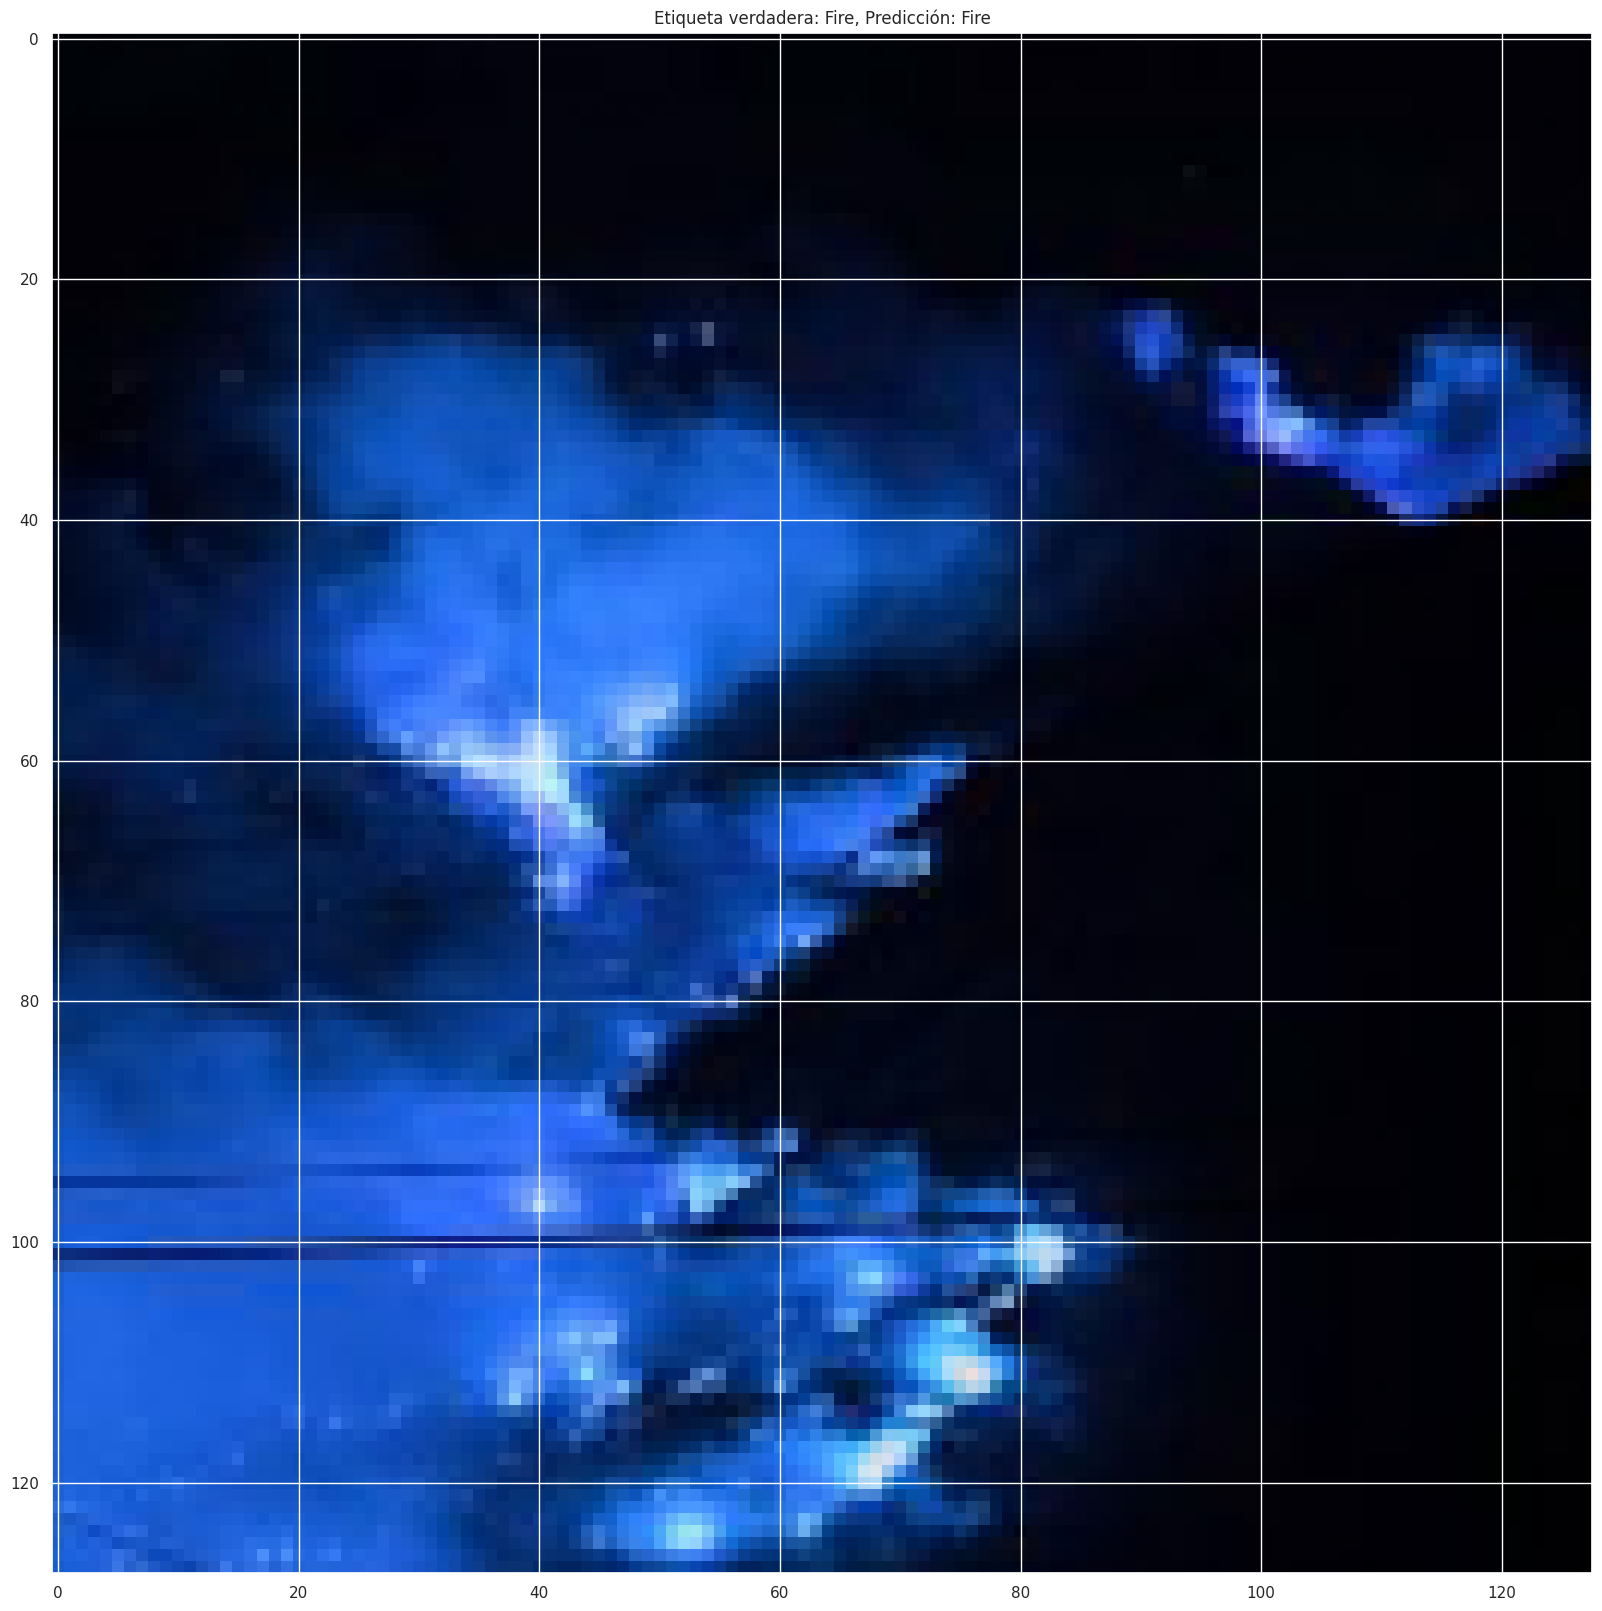

In [ ]:
probar_modelo_con_imagen_aleatoria(model, X_test, y_test, map_characters)